<a href="https://colab.research.google.com/github/jsebastianquiroga/Big_Data_Derby_2022_SI/blob/main/Notebooks/sistemas_inteligentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: center; padding-right: 10px;" src="https://www.pikpng.com/pngl/b/467-4670553_universidad-javeriana-esslingen-am-neckar-clipart.png" width="100" height="150">




***Integrantes:***

**Joshep Andersson Blanco Reyes**

**Leonardo García Diaz**

**Juan Sebastián Quiroga Bernal**

# <img style="float: left; padding-right: 10px;" src="https://images7.alphacoders.com/671/671791.jpg"  height="300">




**Este colab puede ser ejecutado por cualquier usuario sin necesidad de cargar los archivos al entorno, debido a que la conexión está configurada para acceder a los archivos desde la nube**.


<h1> <strong>Big Data Derby 2022.</strong></h1> 

Los Derbies como se conocen, es un tipo de carreras de caballos, inventada alrededor de 1780 en Inglaterra, cuyos participantes son los jinetes y sus caballos, los cuales deben ser mayores a 3 años.



En esta ocasión se tomará como fuente de información una competencia de Kaggle , nombrada Big Data Derby 2022 (https://www.kaggle.com/competitions/big-data-derby-2022/overview), en donde se relacionan observaciones de 2000 carreras entre 2019-01 al 2020-01, de tres de sus principales circuitos AQU -Aqueduct, BEL - Belmont, SAR – Saratoga. 


El objetivo de este estudio es analizar las carreras de caballos, con el fin de desarrollar diferentes modelos, que permitan predecir si un caballo terminara entre los 3 primeros para intentar predecir las apuestas que aumentaran el retorno de inversión.



Su trabajo ayudará a los propietarios, entrenadores y veterinarios de caballos de carreras a comprender mejor cómo encajan el rendimiento y el bienestar de los equinos. Con un mejor análisis de datos. 

El presente notebook, estará dividido en divido en las siguientes partes:
<ol>
<li> Analisis exploratorio. </li>
<li> Modelo ingenuo: Sistema experto. </li>
<li> Modelo ingenuo: Sistema Rede Neuronal I. </li>
<li> Modelo ingenuo: Sistema Rede Neuronal II. </li>
<li> Conclusiones: Modelos ingenuos. </li>
<li> Algoritmo genetico: Selección de variables. </li>
<li> Algoritmo genetico: Selección de hiper-parametos con los features seleccionados. </li>
<li> Red Neuronal entrenada con algoritmo geneticos.</li>
<li> Conclusiones.</li> 
</ol>

***

# <h1><strong> 1. Analisis exploratorio. <h1><strong>

In [1]:

# Conexion a gdrive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
import pandas as pd
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

nyra_2019_complete = '1AAshxhslPjhxg-UC86f9Z97s3W81nayF' #<-- Key del file en drive (nyra_2019_complete.csv 610 mb)
# nyra_race_table    = '1KtYQEvt4pboSqs7bO6jfdCHADo9PMzo9'#<-- Key del file en drive (nyra_race_table.csv 93 kb)
# nyra_start_table   = '1LYUx_De3U7TBw6GgqRk6whVzMjuJjSaz'#<-- Key del file en drive (nyra_start_table.csv 722 Kb)
# nyra_tracking_table= '15y4AtfLiyop9FWdc0SRaMUs-jKgnOppl'#<-- Key del file en drive (nyra_tracking_table.csv 320,7 mb)


download = drive.CreateFile({'id': nyra_2019_complete}) 
# Download the file to a local disc
download.GetContentFile('nyra_2019_complete.csv')
dtype_dict = {"track_id": object ,
              "race_date" :object, #will be read with "parse_dates" parameter
              "race_number" : np.int8, 
              "program_number" : object,
              "trakus_index" : np.int16,  
              "latitude" : np.float64,
              "longitude" : np.float64,
              "distance_id" : np.int16,  
              "course_type" : object, 
              "track_condition" : object,
              "run_up_distance" : np.int8,  
              "race_type" : object, 
              "purse" : np.int32,  
              "post_time" : np.int16,  
              "weight_carried" : np.int16,  
              "jockey" : object, 
              "odds" : np.int16,
              "position_at_finish":np.int8
             }
nyra_2019 = pd.read_csv('nyra_2019_complete.csv', header=None,dtype=dtype_dict,parse_dates=[1])
nyra_2019.columns= dtype_dict.keys()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


***Diccionario de Variables***

<li>track_id - Identificación de 3 caracteres para la pista en la que tuvo lugar la carrera. AQU -Aqueduct, BEL - Belmont, SAR - Saratoga. 

<li> race_date - Fecha en la que tuvo lugar la carrera. YYYY-MM-DD. 

<li> race_number - Número de la carrera. 

<li> program_number - Es el identificador único del caballo en la carrera. 

<li> trakus_index - El seguimiento de un punto de la lat/long del caballo en la carrera pasado como un número entero. Por lo que podemos decir, se recopila cada 0,25 segundos. </li>

<li>latitude- La latitud del caballo en la carrera. 

<li>Longitude - La longitud del caballo en la carrera. 

<li>distance_id- Distancia de la carrera en estadios pasados como un número entero. 

<li>course_type- El recorrido de la carrera pasó como un carácter. M - Hurdle, D - Dirt, O - Outer turf, I - Inner turf, T - turf. 

<li>track_condition- El estado del recorrido en el que se corrió la carrera se transmite en tres caracteres. YL - Yielding, FM - Firm, SY - Sloppy, GD - Good, FT - Fast, MY - Muddy, SF - Soft. 

<li>run_up_distance- Distancia en pies desde la puerta hasta el inicio de la carrera. 

<li>race_type- char - La clasificación de la carrera pasó como cinco caracteres. STK - Stakes, WCL - Waiver Claiming, WMC - Waiver Maiden Claiming, SST - Starter Stakes, SHP - Starter Handicap, CLM - Claiming, STR - Starter Allowance, AOC - Allowance Optionl Claimer, SOC - Starter Optional Claimer, MCL - Maiden Claiming, ALW - Allowance, MSW - Maiden Special Weight. 

<li>post_time - La hora del día en que comenzó la carrera 

<li>weight_carried - Un número entero del peso que lleva el caballo en la carrera 

<li>jockey - Nombre del jockey sobre el caballo en la carrera 

<li>odds - Probabilidades de ganar la carrera 

<li>position_at_finish- Un número entero de la posición final del caballo. 

Se asigno el formato indicado para cada una de las variables antes mencionadas.

In [3]:
nyra_2019.info()
nyra_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   track_id            object        
 1   race_date           datetime64[ns]
 2   race_number         int64         
 3   program_number      object        
 4   trakus_index        int64         
 5   latitude            float64       
 6   longitude           float64       
 7   distance_id         int64         
 8   course_type         object        
 9   track_condition     object        
 10  run_up_distance     int64         
 11  race_type           object        
 12  purse               float64       
 13  post_time           int64         
 14  weight_carried      int64         
 15  jockey              object        
 16  odds                int64         
 17  position_at_finish  int64         
dtypes: datetime64[ns](1), float64(3), int64(8), object(6)
memory usage: 718.0+ MB


,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,position_at_finish
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000.0,420,120,Andre Shivnarine Worrie,2090,8


Se removerán las variables de trakus_index, latitude, longitude, ya que son información geolocalizada tomada durante la carrera, con el fin de predecir que caballo puede ganar antes de la carrera no tiene relación, ademas se creo una llave única para identificar cada carrera individualmente para un total de 2000 carreras.

In [ ]:
nyra_2019 = nyra_2019.drop(['latitude', 'longitude', 'trakus_index'], axis=1)
nyra_2019['unique_id'] = nyra_2019.track_id.astype(str) + '_' + nyra_2019.race_date.astype(str) + '_' + nyra_2019.race_number.astype(str)
print(nyra_2019.unique_id.value_counts())
nyra_2019

In [ ]:
nyra_2019['unique_id'].nunique()

Se eliminaran los valores repetidos, dejando solo una observación por caballo.

In [ ]:
nyra_2019 = nyra_2019.drop_duplicates()

In [ ]:
nyra_2019['track_id'].count()

In [ ]:
nyra_2019['track_id'].value_counts(normalize=True) * 100

In [ ]:
categorical_features = ['track_id','distance_id','course_type','track_condition','race_type']
for f in categorical_features:
    plt.figure(figsize=(10,5))
    if (f=='distance_id'):
        nyra_2019[f].value_counts().sort_index().plot(kind='bar')
    else:
        nyra_2019[f].value_counts().plot(kind='bar')
    plt.title(f)
    plt.grid()
    plt.show()

Según el grafico, se puede observar que la mayoria de las carreras se corrieron en el acueducto.

El valor mas frecuente en las distancias de carrera es 600 pies.

La mayoría de las carreras tienen recorridos en tierra, con un estado tipo rapido.



In [ ]:
numerical_features = ['run_up_distance','purse','post_time']
for f in numerical_features:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6))
    
    ax1.hist(nyra_2019[f], bins=20)
    ax1.grid()
    ax1.set_title(f)
    
    ax2.boxplot(nyra_2019[f], vert=False)
    ax2.grid()   
    ax2.set_title(f)
    
    plt.show()
    print('')

EL run up distance, que mide en pies la distancia desde la puerta hasta el inicio de la carrera, tiene una cola pesada hacia la derecha con algunos valores superiores a los 130 que podrian tomarse como valores poco frecuentes o atipicos.

La mayoria de las carreras son en las horas de la tarde, desde las 12:00 del medio dia hasta las 8:00 pm, siendo 4:00pm la hora mas frecuente, de estos eventos.

In [ ]:
corr_pearson = nyra_2019[numerical_features].corr(method='pearson')
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
sns.heatmap(corr_pearson, annot=True, cmap='YlGnBu', vmin=-1, vmax=+1)
plt.title('Pearson Correlation')

Se percibe una baja relación lineal entre las variables.

In [ ]:
sns.pairplot(nyra_2019, vars=numerical_features,
             hue='track_id',
             palette='YlGnBu',
             plot_kws= {'s' : 10, 'alpha' : 0.5})
plt.show()

No se observa ningun patrón claro, que genere diferenciación entre los 3 circuitos y el resto de las variables.

### ***Comparativo variables vs variable de respuesta (position_at_finish)***

In [ ]:
pd.crosstab(index=nyra_2019['track_id'],
            columns=nyra_2019['position_at_finish']).apply(lambda r: r/r.sum() * 100,
                                                                axis=0)

In [ ]:
s =pd.crosstab(index=nyra_2019['track_id'],
            columns=nyra_2019['position_at_finish']).apply(lambda r: r/r.sum() * 100,
                                                                axis=1)
s

Se obtienen las distribuciones de los tacks ID, el 41% del total de los datos tienen relación con el track id AQU.

Se identifica que en la posisión 13 el 80% de las observaciones tienen relación con ese track ID.

Inicialmente en Saratoga, se identifiarón datos hasta las pocisiones 12, puede ser que en esta pista corran menos caballos en total.

Se observa un decrecimiento porcentual en la cantidad de observaciones, en las posiciones 13 y 14.

In [ ]:
x = pd.crosstab(index=nyra_2019['race_date'],
            columns=nyra_2019['position_at_finish']).apply(lambda r: r/r.sum() * 100,
                                                                axis=0)

x

In [ ]:
x.plot()

Se evidencia un incremento en 3 fechas especificas de la existencia de los puntos 13 y 14. pareceria ser un comportamiento atipico.

In [ ]:
nyra_2019['race_number'].value_counts(normalize=True) * 100

In [ ]:
nyra_2019['race_number'].hist()

In [ ]:
xp = pd.crosstab(index=nyra_2019['race_number'],
            columns=nyra_2019['position_at_finish']).apply(lambda r: r/r.sum() * 100,
                                                                axis=0)
xp

In [ ]:
sns.heatmap(xp)

Se observan que en las carreras 5 y 9 solo se presentarón posiciones 14, y referente a la 13 solo se presentan datos de la carera 5-10 (solo el 38% de las occurrencias)

In [ ]:
nyra_2019['program_number'].value_counts(normalize=True) * 100

In [ ]:
plt.figure(figsize=(10,5))
nyra_2019.program_number.value_counts().plot(kind='bar')
plt.title('Program Number - Count')
plt.grid()
plt.show()

In [ ]:
xpp = pd.crosstab(index=nyra_2019['program_number'],
            columns=nyra_2019['position_at_finish']).apply(lambda r: r/r.sum() * 100,
                                                                axis=0)
xpp

In [ ]:
sns.heatmap(xpp)

Se observa que el numero de programa 4, tiene el 8% de observaciones que terminaron en la primera poción, mayor que el resto de obervaciones.

In [ ]:
nyra_2019['distance_id'].value_counts(normalize=True) * 100

In [ ]:
px = pd.crosstab(index=nyra_2019['distance_id'],
            columns=nyra_2019['position_at_finish']).apply(lambda r: r/r.sum() * 100,
                                                                axis=0)
px

In [ ]:
nyra_2019['course_type'].value_counts(normalize=True) * 100

In [ ]:
pxp = pd.crosstab(index=nyra_2019['course_type'],
            columns=nyra_2019['position_at_finish']).apply(lambda r: r/r.sum() * 100,
                                                                axis=0)
pxp

In [ ]:
nyra_2019['track_condition'].value_counts(normalize=True) * 100

In [ ]:
pxp = pd.crosstab(index=nyra_2019['track_condition'],
            columns=nyra_2019['position_at_finish']).apply(lambda r: r/r.sum() * 100,
                                                                axis=0)
pxp

In [ ]:
nyra_2019['race_type'].value_counts(normalize=True) * 100

In [ ]:
rt = pd.crosstab(index=nyra_2019['race_type'],
            columns=nyra_2019['position_at_finish']).apply(lambda r: r/r.sum() * 100,
                                                                axis=0)
rt

Se eliminan las obervaciones de las posiciones 13 y 14

In [ ]:
nyra_2019 = nyra_2019[(nyra_2019['position_at_finish']!=13)&(nyra_2019['position_at_finish']!=14)]

In [ ]:
nyra_2019.jockey.value_counts()

In [ ]:
plt.figure(figsize=(10,5))

nyra_2019.jockey.value_counts()[0:20].plot(kind='bar')

plt.title('Jockey - Top 20')

plt.grid()

plt.show()

In [ ]:
plt.figure(figsize=(10,5))
nyra_2019.odds.plot(kind='hist', bins=50)
plt.title('Odds')
plt.grid()
plt.show()

# <h1><strong> 2. Modelo ingenuo: Sistema experto </h1></strong>

Entendiendo que las variables que trackean cada 15 segundos la posición en la carrera (latitud, longitud y track index), vamos inicialmente a tomar los valores únicos para que éstos sirvan para hacer una predicción sencilla, tanto de reglas, como de red neuronal.

In [ ]:
nyra_2019_naive = nyra_2019[[
    "track_id",
    "race_date",
    "race_number",
    "program_number",
    "distance_id",
    "course_type",
    "track_condition",
    "run_up_distance",
    "race_type",
    "purse",
    "weight_carried",
    "odds",
    "position_at_finish",
    "jockey"
]]
nyra_2019_naive.head()

In [ ]:
nyra_2019_naive=nyra_2019_naive.drop_duplicates()

Teniendo los datos únicos por carrera podemos ejecutar un modelo naive y un modelo de red neuronal.

Para este caso vamos a intentar predecir si el caballo quedó entre los ***cinco primeros*** (Variable categórica) y así hacer una matriz de confusión con los aciertos.

In [ ]:
nyra_2019_naive['First_3'] = 'Unknown'
nyra_2019_naive.loc[nyra_2019_naive['position_at_finish'].between(0, 4, inclusive=False), 'First_3'] = 1
nyra_2019_naive.loc[nyra_2019_naive['position_at_finish'].between(4, 60, inclusive=True), 'First_3'] = 0

El modelo Naive más sencillo es ordenar los odds de menor a mayor, porque a mayor odds las casas de apuestas pagan más, esto quiere decir que si las casas de apuestas tienen un odds muy bajo, es porque probablemente el corredor va a ganar la carrera.

In [ ]:
nyra_2019_naive=nyra_2019_naive.sort_values(by=['race_date','track_id','race_number', 'odds'], ascending=True, na_position='first')
nyra_2019_naive.head()

In [ ]:
nyra_2019_naive

In [ ]:
##Carrera de ejemplo

nyra_2019_naive[(nyra_2019_naive['race_date']=='2019-01-01') & (nyra_2019_naive['race_number'] == 9)].sort_values(by='odds', ascending=True, na_position='first')


Tomando la carrera 9 del primero de enero del 2019, podemos observar que si ordenamos por odds, de las primeras 3 posiciones reales, el odd estuvo en una de ellas (acertó el ganador.)

Esta lógica es importante porque al separar el train y el test las predicciones no son independientes, y se debe hacer esta separación por carreras (80% carreras en train y 20% de carreras en test).

En éste caso vamos a predecir como los primeros 3 a los odds más bajos, como los que llegaron de primeras, esta sería nuestra predicción.

In [ ]:
first_ods=nyra_2019_naive.groupby(["race_date", "race_number"]).head(3).reset_index(
    drop=True
).sort_values(
    by=["race_date", "track_id", "race_number", "odds"],
    ascending=True,
    na_position="first",
)

first_ods['prediction'] = '1'
first_ods=first_ods[['race_date','race_number','program_number', 'prediction']]

Ahora vamos a integrar esta predicción naive a la base inicial.

In [ ]:
nyra_2019_naive=nyra_2019_naive.merge(first_ods, on=['race_date','race_number','program_number'], how='left').sort_values(by=['race_date','track_id','race_number', 'odds'], ascending=True, na_position='first')
nyra_2019_naive['prediction'] = nyra_2019_naive['prediction'].fillna(0)
nyra_2019_naive

Métricas regla de asociación (Con todos los datos)

**Para facilitar la comparabilidad con los modelos de redes neuronales, también se añadió la métrica de asociación solamente para los datos de test**

El modelo acierta en un 69% de las veces si la posición estará dentro o fuera del top 3 de la carrera, el tener una precisión mayor al 50% se admite como modelo naive.

Recordar que la matriz de confusión de sklearn se muestra el revés, es decir la clase 1,1 (está en el top tres) es la de 2.692.
https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

nyra_2019_naive['First_3']=nyra_2019_naive['First_3'].astype(int)
nyra_2019_naive['prediction']=nyra_2019_naive['prediction'].astype(int)

In [ ]:
#confusion_matrix((nyra_2019_naive['First_3']), (nyra_2019_naive['prediction']))
#accuracy_score(nyra_2019_naive['First_3'], nyra_2019_naive['prediction'], normalize=True)
#tn, fp, fn, tp = confusion_matrix(nyra_2019_naive['First_3'], nyra_2019_naive['prediction']).ravel()
#(tn, fp, fn, tp)
#3696/(2304+3696)
#696/(3696+2372)

In [ ]:
print('Precision:',precision_score(nyra_2019_naive['First_3'], nyra_2019_naive['prediction']))
print('Recall:',recall_score(nyra_2019_naive['First_3'], nyra_2019_naive['prediction']))
print('Accuracy:',accuracy_score(nyra_2019_naive['First_3'], nyra_2019_naive['prediction']))

In [ ]:
d = {'Modelo': ['Sistema_experto'], 
     'Precision': [precision_score(nyra_2019_naive['First_3'], nyra_2019_naive['prediction'])], 
     'Recall': recall_score(nyra_2019_naive['First_3'], nyra_2019_naive['prediction']),
     'Accuracy': accuracy_score(nyra_2019_naive['First_3'], nyra_2019_naive['prediction'])}
Resultados = pd.DataFrame(data=d)
Resultados

# <h1><strong> 3. Modelo ingenuo: Sistema Rede Neuronal I.</h1></strong>



División Test Train

La división se va a hacer de manera secuencial, ordenada por fecha y tomaremos el 70% (1400 carreras como train y 600 carreras como test.)

In [ ]:
nyra_2019_naive[["race_date", "track_id", "race_number"]].drop_duplicates()
#Ordeno por fecha
test=nyra_2019_naive[["race_date", "track_id", "race_number"]].drop_duplicates().head(600)
train=nyra_2019_naive[["race_date", "track_id", "race_number"]].drop_duplicates().tail(1400)
#Traigo 70% de las carreras para train y el 30% para test
train=train.merge(nyra_2019_naive, on=['race_date','race_number','track_id'], how='left').sort_values(by=['race_date','track_id','race_number', 'odds'], ascending=True, na_position='first')
test=test.merge(nyra_2019_naive, on=['race_date','race_number','track_id'], how='left').sort_values(by=['race_date','track_id','race_number', 'odds'], ascending=True, na_position='first')
train

Ordenamos las carreras por fecha y escogemos el 70% de las carreras para train y el 30% de las carreras para test

Para facilidad del algoritmo escogemos 4 variables continuas para predecir si en la carrera acabaron entre los 3 primeros.

Damos forma la los inputs de la red neuronal.

In [ ]:
TargetVariable=['First_3']
Predictors=['run_up_distance','purse'	,'weight_carried'	,'odds'	]

X_train=train[Predictors]
y_train=train[TargetVariable]
X_test=test[Predictors]
y_test=test[TargetVariable]

X_train=np.asarray(X_train).astype(np.float32)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Para ésta red neuronal, se toman 4 inputs **('run_up_distance','purse'	,'weight_carried'	,'odds')**, 5 unidades en la primera capa con activación relu.

Luego, se añaden 4 neuronas con activación relu y 1 capa final con activación sigmoide.

Luego se compila con un optimizador Adam, una activación sigmoide y una función de pérdida binary_crossentropy.

La red se pasará por 5 épocas, con un batch size de 64.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
classifier = Sequential()
# Defining the Input layer and FIRST hidden layer,both are same!
# relu means Rectifier linear unit function
classifier.add(Dense(units=5, input_dim=4, kernel_initializer='uniform', activation='relu'))
 
#Defining the SECOND hidden layer, here we have not defined input because it is
# second layer and it will get input as the output of first hidden layer
classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
 
# Optimizer== the algorithm of SGG to keep updating weights
# loss== the loss function to measure the accuracy
# metrics== the way we will compare the accuracy after each step of SGD
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
# fitting the Neural Network on the training data
classifier.fit(X_train,y_train, batch_size=64 , epochs=5, verbose=1)


#dataframe=pd.DataFrame(classifier.predict(X_test).tolist())

#dataframe['prediction'] = 'Unknown'
#dataframe.loc[(dataframe[0]<0.5) & (dataframe[0]>0), 'prediction'] = 0
#dataframe.loc[(dataframe[0]>0.5) , 'prediction'] = 1
#confusion_matrix((y_test), dataframe[['prediction']].astype(int))

#confusion_matrix((nyra_2019_naive['First_3']), (nyra_2019_naive['prediction']))
#accuracy_score(y_test, dataframe[['prediction']].astype(int), normalize=True)
#tn, fp, fn, tp = confusion_matrix(y_test, dataframe[['prediction']].astype(int)).ravel()
#(tn, fp, fn, tp)
#tp/(tp+fp)
#tp/(tp+fn)

In [ ]:
y_pred = classifier.predict(X_test.values)

In [ ]:
#y_pred = np.where(y_pred <0.5, 0, 1)
print('Precision:',precision_score(y_test, y_pred.round()))
print('Recall:',recall_score(y_test,y_pred.round()))
print('Accuracy:',accuracy_score(y_test,y_pred.round()))

In [ ]:
d1 = {'Modelo': ['Redes_1'], 
     'Precision': precision_score(y_test, y_pred.round()), 
     'Recall': recall_score(y_test, y_pred.round()),
     'Accuracy': accuracy_score(y_test, y_pred.round())}
Resultados1 = pd.DataFrame(data=d1)

Resultados = Resultados.append(Resultados1, ignore_index=True)
Resultados

# <h1><strong> 4. Modelo ingenuo: Sistema Rede Neuronal II .</h1></strong>

In [ ]:
train.columns

In [ ]:
TargetVariable=['First_3']
Predictors=['run_up_distance'	,'weight_carried'	,'odds'	]

X_train=train[Predictors]
y_train=train[TargetVariable]
X_test=test[Predictors]
y_test=test[TargetVariable]


from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing

early_stopping = EarlyStopping()
classifier2 = Sequential()
classifier2.add(Dense(units=3, input_dim=3, activation='sigmoid'))
classifier2.add(Dense(units=14, activation='sigmoid'))
 
classifier2.add(Dense(units=1, activation='relu'))
 
classifier2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
 
# fitting the Neural Network on the training data
classifier2.fit(X_train,y_train, batch_size=32 , epochs=10, verbose=1, callbacks=[early_stopping])

#df =pd.DataFrame(classifier2.predict(X_test).tolist())
##df =pd.DataFrame(classifier2.predict(X_test).tolist())
#df ['prediction'] = 'Unknown'
#df.loc[(df[0]<0.50) & (df[0]>0), 'prediction'] = 0
#df.loc[(df[0]>0.50) , 'prediction'] = 1
#confusion_matrix((y_test), df[['prediction']].astype(int))
#accuracy_score(y_test, df[['prediction']].astype(int), normalize=True)
#tn, fp, fn, tp = confusion_matrix(y_test, df[['prediction']].astype(int)).ravel()
#(tn, fp, fn, tp)
#tp/(tp+fp)
#tp/(tp+fn)

In [ ]:
y_pred2 = classifier2.predict(X_test.values)

In [ ]:
#y_pred2 = np.where(y_pred2 <0.5, 0, 1)
print('Precision:',precision_score(y_test, y_pred2.round()))
print('Recall:',recall_score(y_test,y_pred2.round()))
print('Accuracy:',accuracy_score(y_test,y_pred2.round()))

In [ ]:
d2 = {'Modelo': ['Redes_2'], 
     'Precision': precision_score(y_test, y_pred2.round()), 
     'Recall': recall_score(y_test, y_pred2.round()),
     'Accuracy': accuracy_score(y_test, y_pred2.round())}
Resultados2 = pd.DataFrame(data=d2)

Resultados = Resultados.append(Resultados2, ignore_index=True)
Resultados

# <h1><strong> 5. Conclusiones: Modelos ingenuos.</h1></strong>

**Accuracy**

Red Neuronal 1 **66,5%**

Red Neuronal 2 **69,17%**

Naive **68,07%**

***Precision*** (TP/(TP+FP))


Red Neuronal 1 **58,4%**

Red Neuronal 2 **65.8%**

Naive **62,67%**


***Sensibilidad*** (TP/(tp+fn))

Red Neuronal 1 **74,28%**

Red Neuronal 2 **57,43**

Naive          **62,11%**


En general los tres modelos tienen métricas similares.

La red neuronal 2 destaca por tener una presición alta (**buena capacidad para detectar a los 3 primeros de una carrera**) y tener un accuracy un poco mejor que los otros dos modelos llevados a cabo.

Sin embargo la red neuronal 1 tiene mayor sensibilidad, es decir, detecta casi el 74% correctamente los verdaderos  positivos, es decir los tres primeros en llegar a la meta, debido a que ésta es la métrica que más nos interesa, dado que la precisión es similar, el modelo que más nos ayuda a la predicción, es la red neuronal 2.

Aún estos modelos no consideran datos como la longitud y la latitud en la carrera, algo que en el futuro nos puede mejorar la predicción actual.

Se comprueba adicionalmente que el modelo de recomendación dado los odds (o el pago estimado de la casa de apuesta) tienen una naturaleza predictiva frente a quién ganará la carrera.

# <h1><strong> 6. Algoritmo genetico: Selección de variables.</h1></strong>

In [327]:
pip install sklearn-genetic-opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [328]:
pip install sklearn-genetic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from genetic_selection import GeneticSelectionCV
# estimator = RandomForestClassifier(max_depth=6, random_state=0)
# model = GeneticSelectionCV(
#     estimator, cv=5, verbose=0,
#     scoring="accuracy", n_population=15, crossover_proba=0.5,
#     mutation_proba=0.2, n_generations=50,
#     crossover_independent_proba=0.5,
#     mutation_independent_proba=0.04,
#     tournament_size=3, n_gen_no_change=10,
#     caching=True, n_jobs=-1)
# model = model.fit(X_train, y_train)
# print('Features:', X_train.columns[model.support_])

In [ ]:
import matplotlib.pyplot as plt
from sklearn_genetic import GAFeatureSelectionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
data = nyra_2019.copy()
data = data.drop('jockey', axis=1)
test=data[["race_date", "track_id", "race_number"]].drop_duplicates().head(600)
train=data[["race_date", "track_id", "race_number"]].drop_duplicates().tail(1400)
data['First_3'] = 0
data.loc[data['position_at_finish'].between(0, 4, inclusive=False), 'First_3'] = 1
# data.loc[data['position_at_finish'].between(4, 60, inclusive=True), 'First_3'] = 0
#Traigo 70% de las carreras para train y el 30% para test
data = data.drop(['unique_id', 'position_at_finish'], axis=1)
data =  pd.get_dummies(data, columns=['track_condition', 'course_type', 'race_type', 'program_number'], dtype='float')
data_F = data.copy()
train=train.merge(data_F, on=['race_date','race_number','track_id'], how='left').sort_values(by=['race_date','track_id','race_number', 'odds'], ascending=True, na_position='first')
test=test.merge(data_F, on=['race_date','race_number','track_id'], how='left').sort_values(by=['race_date','track_id','race_number', 'odds'], ascending=True, na_position='first')
train = pd.get_dummies(train, columns=['track_id'], dtype='float')
test = pd.get_dummies(test, columns=['track_id'], dtype='float')
train = train.drop('race_date', axis=1)
test = test.drop('race_date', axis=1)
X_train, y_train = train.drop('First_3', axis=1), train['First_3']
X_test, y_test = test.drop('First_3', axis=1), test['First_3']

In [332]:
clf = RandomForestClassifier()
evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    scoring="accuracy",
    population_size=15,
    generations=15,
    n_jobs=-1)
# Entrena y selecciona las variables 
evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	15    	0.623228	0.0624058  	0.676878   	0.51677    
1  	30    	0.670895	0.00627743 	0.676878   	0.648585   
2  	30    	0.673381	0.00189874 	0.676878   	0.669384   
3  	30    	0.675304	0.00183081 	0.678658   	0.671819   
4  	30    	0.675917	0.00154414 	0.678658   	0.673412   
5  	30    	0.676323	0.00174012 	0.678658   	0.673506   
6  	30    	0.677128	0.00173952 	0.679502   	0.674068   
7  	30    	0.677359	0.00176761 	0.679502   	0.673318   
8  	30    	0.677772	0.00134241 	0.678658   	0.673693   
9  	30    	0.677284	0.00152554 	0.678846   	0.673693   
10 	30    	0.67754 	0.00116987 	0.678846   	0.674349   
11 	30    	0.677909	0.00166785 	0.681844   	0.674349   
12 	30    	0.67874 	0.00221116 	0.681844   	0.673599   
13 	30    	0.679021	0.00196899 	0.682031   	0.675754   
14 	30    	0.678121	0.00220469 	0.681844   	0.674068   
15 	30    	0.679539	0.00207433 	0.681844   	0.675192   


GAFeatureSelectionCV(estimator=RandomForestClassifier(), generations=15,
                     n_jobs=-1, population_size=15, return_train_score=True,
                     scoring='accuracy')

In [ ]:
features = evolved_estimator.best_features_
#print(features)
#X_test.columns[features]
variables_imp = X_test[X_test.columns[features]]
variables_imp

In [ ]:
# Predict only with the subset of selected features
X_trainn = X_train.to_numpy()
X_testt = X_test.to_numpy()
y_predict_ga = evolved_estimator.predict(X_testt[:, features])
#accuracy = accuracy_score(y_test, y_predict_ga)


In [ ]:
print('Precision:',precision_score(y_test, y_predict_ga))
print('Recall:',recall_score(y_test,y_predict_ga))
print('Accuracy:',accuracy_score(y_test,y_predict_ga))

In [ ]:
d3 = {'Modelo': ['Gen_FI'], 
     'Precision': precision_score(y_test, y_predict_ga), 
     'Recall': recall_score(y_test, y_predict_ga),
     'Accuracy': accuracy_score(y_test, y_predict_ga)}
Resultados3 = pd.DataFrame(data=d3)

Resultados = Resultados.append(Resultados3, ignore_index=True)
Resultados

# <h1><strong> 7.Algoritmo genetico: Selección de hiper-parametos con los features seleccionados.</strong></h1>

In [337]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 30), 
              'max_leaf_nodes': Integer(2, 35), 
              'n_estimators': Integer(100, 300)}

cv = StratifiedKFold(n_splits=3, shuffle=True)

evolved_estimator = GASearchCV(estimator=clf,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=20,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [338]:
evolved_estimator.fit(X_trainn[:,features],y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.641934	0.0425077  	0.696646   	0.602024   
1  	20    	0.683324	0.0272999  	0.697396   	0.602024   
2  	19    	0.694126	0.00269334 	0.697489   	0.690275   
3  	18    	0.697189	0.00191348 	0.699644   	0.694117   
4  	19    	0.698988	0.00129476 	0.700393   	0.696178   
5  	17    	0.699934	0.00129167 	0.70133    	0.69674    
6  	15    	0.700824	0.000763638	0.701892   	0.700019   
7  	18    	0.701265	0.00112583 	0.702923   	0.699363   
8  	19    	0.70193 	0.000920029	0.702923   	0.700487   
9  	18    	0.702014	0.00132296 	0.702923   	0.698895   
10 	18    	0.70148 	0.00154522 	0.702923   	0.698895   
11 	18    	0.701939	0.00135715 	0.702923   	0.699831   
12 	17    	0.701902	0.0014291  	0.702923   	0.699269   
13 	18    	0.700946	0.00157127 	0.702923   	0.698239   
14 	20    	0.702164	0.000922173	0.702923   	0.700206   
15 	18    	0.70163 	0.00171565 	0.702923   	0.698145   
16 	19    	0.702314	0.00117705 	0.702923   	0.69

GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
           estimator=RandomForestClassifier(max_depth=30, max_leaf_nodes=26,
                                            min_weight_fraction_leaf=0.010177574417251091,
                                            n_estimators=241),
           generations=20, keep_top_k=4, mutation_probability=0.1, n_jobs=-1,
           param_grid={'bootstrap': <sklearn_genetic.space.space.Categor...
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x7fbc990abb90>,
                       'max_leaf_nodes': <sklearn_genetic.space.space.Integer object at 0x7fbc990ab350>,
                       'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x7fbc990abf50>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x7fbc990ab650>},
           population_size=10, return_train_score=True, scoring='accuracy'

In [339]:
evolved_estimator.best_params_

{'min_weight_fraction_leaf': 0.010177574417251091,
 'bootstrap': True,
 'max_depth': 30,
 'max_leaf_nodes': 26,
 'n_estimators': 241}

In [340]:
y_predicy_ga2 = evolved_estimator.predict(X_testt[:,features])
#accuracy_score(y_test,y_predicy_ga)

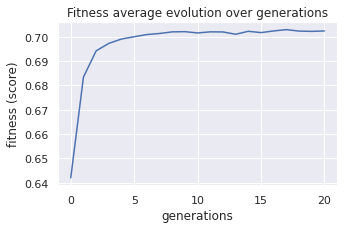

In [341]:
plt.figure(figsize=(5,3))
plot_fitness_evolution(evolved_estimator)
plt.show()

In [342]:
print("Parámetros y sus cv_scores in cada iteración:")
print(evolved_estimator.logbook)

Parámetros y sus cv_scores in cada iteración:
                                                                                                                                                        parameters                                                                                                                                                        
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
bootstrap	cv_scores                         	fit_time                          	index	max_depth	max_leaf_nodes	min_weight_fraction_leaf	n_estimators	score   	score_time                        	test_score                        	train_score                       
False    	[0.68943227 0.69392917 0.68858909]	[1.88712382 1.86

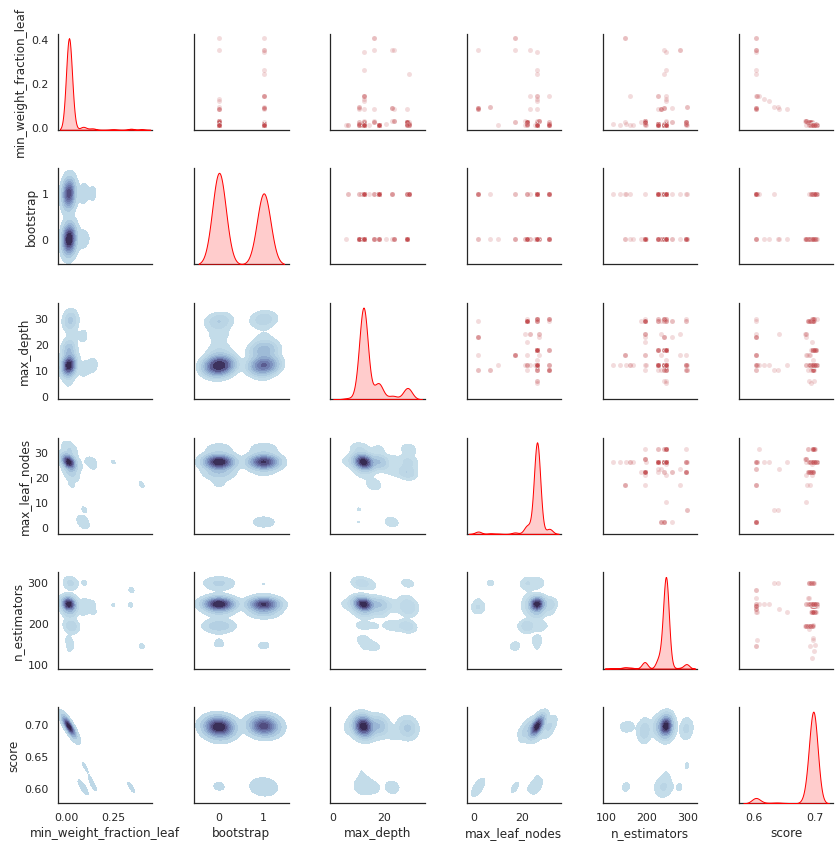

In [343]:
import warnings
warnings.filterwarnings('ignore')

plot_search_space(evolved_estimator)
plt.show()

In [344]:
print("Mejores k soluciones:")
print(evolved_estimator.hof)

Mejores k soluciones:
{0: {'min_weight_fraction_leaf': 0.010177574417251091, 'bootstrap': True, 'max_depth': 30, 'max_leaf_nodes': 26, 'n_estimators': 241}, 1: {'min_weight_fraction_leaf': 0.010177574417251091, 'bootstrap': True, 'max_depth': 18, 'max_leaf_nodes': 26, 'n_estimators': 228}, 2: {'min_weight_fraction_leaf': 0.010177574417251091, 'bootstrap': True, 'max_depth': 18, 'max_leaf_nodes': 26, 'n_estimators': 247}, 3: {'min_weight_fraction_leaf': 0.010177574417251091, 'bootstrap': True, 'max_depth': 12, 'max_leaf_nodes': 26, 'n_estimators': 247}}


In [345]:
print('Precision:',precision_score(y_test, y_predicy_ga2))
print('Recall:',recall_score(y_test,y_predicy_ga2))
print('Accuracy:',accuracy_score(y_test,y_predicy_ga2))

Precision: 0.6330845771144279
Recall: 0.5593406593406594
Accuracy: 0.6834924965893588


In [346]:
d4 = {'Modelo': ['Gen_HipP'], 
     'Precision': precision_score(y_test, y_predicy_ga2), 
     'Recall': recall_score(y_test, y_predicy_ga2),
     'Accuracy': accuracy_score(y_test, y_predicy_ga2)}
Resultados4 = pd.DataFrame(data=d4)

Resultados = Resultados.append(Resultados4, ignore_index=True)
Resultados

,Modelo,Precision,Recall,Accuracy
0,Sistema_experto,0.616000,0.609097,0.689756
1,Redes_1,0.695581,0.468062,0.685915
2,Redes_2,0.000000,0.000000,0.573709
3,Gen_FI,0.617059,0.576374,0.676671
4,Gen_HipP,0.633085,0.559341,0.683492


# <h1><strong>8.Red Neuronal entrenada con algoritmo geneticos.</strong></h1>


In [347]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense

In [348]:
data = nyra_2019.copy()
data = data.drop('jockey', axis=1)
test=data[["race_date", "track_id", "race_number"]].drop_duplicates().head(600)
train=data[["race_date", "track_id", "race_number"]].drop_duplicates().tail(1400)
data['First_3'] = 0
data.loc[data['position_at_finish'].between(0, 4, inclusive=False), 'First_3'] = 1
# data.loc[data['position_at_finish'].between(4, 60, inclusive=True), 'First_3'] = 0
#Traigo 70% de las carreras para train y el 30% para test
data = data.drop(['unique_id', 'position_at_finish'], axis=1)
data =  pd.get_dummies(data, columns=['track_condition', 'course_type', 'race_type', 'program_number'], dtype='float')
data_F = data.copy()
train=train.merge(data_F, on=['race_date','race_number','track_id'], how='left').sort_values(by=['race_date','track_id','race_number', 'odds'], ascending=True, na_position='first')
test=test.merge(data_F, on=['race_date','race_number','track_id'], how='left').sort_values(by=['race_date','track_id','race_number', 'odds'], ascending=True, na_position='first')
train = pd.get_dummies(train, columns=['track_id'], dtype='float')
test = pd.get_dummies(test, columns=['track_id'], dtype='float')
train = train.drop('race_date', axis=1)
test = test.drop('race_date', axis=1)
X_train, y_train = train.drop('First_3', axis=1), train['First_3']
X_test, y_test = test.drop('First_3', axis=1), test['First_3']
X_train = X_train[X_train.columns[features]]
X_test = X_test[X_test.columns[features]]
nl = X_train.shape[1]

In [349]:
# Se define la clase de la red genetica.
class GeneticNeuralNetwork(Sequential):
    def __init__(self, child_weights=None): #Si los pesos no son informados se generan 'random'
        super().__init__()
        if child_weights is None:
            # Los 'Layers' se crean 'random', definiendo funcion de activación sigmoide.
            # se agregan los 'Layers' al modelo.
            layer1 = Dense(nl, input_shape=(nl,), activation='sigmoid')
            layer2 = Dense(2, activation='sigmoid')
            layer3 = Dense(1, activation='sigmoid')
            self.add(layer1)
            self.add(layer2)
            self.add(layer3)
        # Si los pesos son informados, se establecen al modelo.
        else:
            self.add(
                Dense(
                    nl,
                    input_shape=(nl,),
                    activation='sigmoid',
                    weights=[child_weights[0], np.zeros(nl)])
                )
            self.add(
                Dense(
                 2,
                 activation='sigmoid',
                 weights=[child_weights[1], np.zeros(2)])
            )
            self.add(
                Dense(
                 1,
                 activation='sigmoid',
                 weights=[child_weights[2], np.zeros(1)])
            )

    # Función de forward propagation
    def forward_propagation(self, X_train, y_train):
        y_hat = self.predict(X_train.values)
        # Se define el precision como funcion de fitness.
        self.fitness = precision_score(y_train, y_hat.round())
    # Backpropagation
    def compile_train(self, epochs):
        self.compile(
                      optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy']
                      )
        self.fit(X_train.values, y_train.values, epochs=epochs)

# Mutación.
def mutation(child_weights):
    selection = random.randint(0, len(child_weights)-1)
    mut = random.uniform(0, 1)
    if mut >= .5:
        child_weights[selection] *= random.randint(2, 5)
    else:
        # No mutation
        pass
# Cruses entre dos redes geneticas.
def dynamic_crossover(nn1, nn2):
    nn1_weights = []
    nn2_weights = []
    child_weights = []
    #obtener pesos.
    for layer in nn1.layers:
        nn1_weights.append(layer.get_weights()[0])
    for layer in nn2.layers:
        nn2_weights.append(layer.get_weights()[0])

    # Se obtienen todos los pesos de la capas para crossover.
    for i in range(0, len(nn1_weights)):
        split = random.randint(0, np.shape(nn1_weights[i])[1]-1)
        for j in range(split, np.shape(nn1_weights[i])[1]-1):
            nn1_weights[i][:, j] = nn2_weights[i][:, j]

        # Se añaden los pesos a los hijos.
        child_weights.append(nn1_weights[i])

    mutation(child_weights)

    child = GeneticNeuralNetwork(child_weights)
    return child

In [350]:
# Crear lista para al redes, generaciones y se define 20 como population.
networks = []
pool = []
generation = 0
n = 20
# Se inicializan los pesos aleatoriamente.
for i in range(0, n):
    networks.append(GeneticNeuralNetwork())
max_fitness = 0
optimal_weights = []
# Loop evolutivo
while max_fitness < .7:
    # Registro de la generación.
    generation += 1
    print('Generation: ', generation)
    # Forward propagation, con base en el accuracy.(function fitness)
    for nn in networks:
        nn.forward_propagation(X_train, y_train)
        # Se agrega al pool.
        pool.append(nn)
    # Se limpia para los proximos hijos
    networks.clear()
    # Organiza basado en el fitness.
    pool = sorted(pool, key=lambda x: x.fitness)
    pool.reverse()
    # Encuentra el maximo fitness y el registro con pesos asociados.
    for i in range(0, len(pool)):
        if pool[i].fitness > max_fitness:
            max_fitness = pool[i].fitness
            print('Max Fitness: ', max_fitness)
            # Reset optimal_weights
            optimal_weights = []
            # Encuentra el maximo fitness y el registro con pesos asociados.
            for layer in pool[i].layers:
                optimal_weights.append(layer.get_weights()[0])
            print(optimal_weights)

    # Crossover, Seleccion del top 5 aleatoriamente selecciona 2 patrones para el hijo.
    for i in range(0, 5):
        for j in range(0, 2):
            # Se crea un hijo y se agrega a las redes
            temp = dynamic_crossover(pool[i], random.choice(pool))
            # Se agrega la red para validar fitness
            networks.append(temp)
# Se crea una red con los pesos optimos obtenidos.
gnn = GeneticNeuralNetwork(optimal_weights)
gnn.compile_train(10)

Generation:  1
334/334 [==============================] - 0s 1ms/step
Max Fitness:  0.43232060527249083
[array([[ 0.08391461, -0.1064512 , -0.07886967, ..., -0.13855205,
        -0.26572242,  0.15627122],
       [ 0.19882804,  0.01942438, -0.24969101, ..., -0.19988272,
        -0.17263669, -0.10089915],
       [ 0.100867  , -0.20730808,  0.16859552, ...,  0.2701479 ,
        -0.13360815, -0.25351578],
       ...,
       [ 0.05113178, -0.24975029,  0.03735924, ..., -0.10198687,
        -0.00153971, -0.15952872],
       [-0.27326173, -0.08335136, -0.23680712, ..., -0.22572526,
         0.17645141, -0.07584335],
       [ 0.17598611, -0.16157585, -0.01664925, ..., -0.12360087,
        -0.23717557, -0.28052133]], dtype=float32), array([[-0.30246225,  0.35740668],
       [-0.25331777, -0.28532705],
       [ 0.17171079,  0.02837932],
       [ 0.14281106, -0.00852418],
       [-0.07532361,  0.14844716],
       [ 0.3571422 , -0.22269721],
       [ 0.3570615 , -0.17045072],
       [-0.0325247 , 

In [351]:
# Test the Genetic Neural Network Out of Sample
y_hat = gnn.predict(X_test.values)
#print('Test Accuracy: %.2f' % accuracy_score(y_test, y_hat.round()))

138/138 [==============================] - 0s 1ms/step


In [353]:
print('Precision:',precision_score(y_test, y_hat.round()))
print('Recall:',recall_score(y_test,y_hat.round()))
print('Accuracy:',accuracy_score(y_test,y_hat.round()))

Precision: 0.6311526479750779
Recall: 0.5565934065934066
Accuracy: 0.6819008640291041


In [356]:
d5 = {'Modelo': ['Gen_Red'], 
     'Precision': precision_score(y_test, y_hat.round()), 
     'Recall': recall_score(y_test, y_hat.round()),
     'Accuracy': accuracy_score(y_test, y_hat.round())}
Resultados5 = pd.DataFrame(data=d5)

Resultados = Resultados.append(Resultados5, ignore_index=True)
Resultados

,Modelo,Precision,Recall,Accuracy
0,Sistema_experto,0.616000,0.609097,0.689756
1,Redes_1,0.695581,0.468062,0.685915
2,Redes_2,0.000000,0.000000,0.573709
3,Gen_FI,0.617059,0.576374,0.676671
4,Gen_HipP,0.633085,0.559341,0.683492
5,Gen_Red,0.631153,0.556593,0.681901
